In [1]:
import sys
sys.path.append('../support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
from sampler import fitters
from astropy.table import Table
import GCRCatalogs



Make sure we know which version we're using

In [2]:
clmm.__version__

'0.2.0'

#### Read in the extragalactic catalog

In [3]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [4]:
cosmo = extragalactic_cat.cosmology

#### Get the list of halos with `M > mmin` in the redshift range `[zmin, zmax]`

In [5]:
# get list of massive halos in a given redshift and mass range
mmin = 3.e14
zmin = 0.3
zmax = 0.4

massive_halos = extragalactic_cat.get_quantities(['halo_mass', 'redshift','ra', 'dec'],\
                                                 filters=[f'halo_mass > {mmin}','is_central==True',
                                                          f'redshift>{zmin}', f'redshift<{zmax}'])


In [6]:
N_cl = len(massive_halos['halo_mass'])
print(f'There are {N_cl} clusters available')

# Selecting the most massive one
select = massive_halos['halo_mass'] == np.max(massive_halos['halo_mass'])

There are 9 clusters available


In [7]:
ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl =massive_halos['halo_mass'][select][0]
print (f'The most massive cluster is in z = {z_cl:.2f}, with mass = {mass_cl:.2e} Msun')

The most massive cluster is in z = 0.32, with mass = 6.36e+14 Msun


### Apply coordinates, redshift and magnitude cuts to select backgroud galaxies around the cluster

In [8]:
# get galaxies around it
ra_min, ra_max = ra_cl-0.3, ra_cl+0.3
dec_min, dec_max = dec_cl-0.3, dec_cl+0.3
z_min = z_cl + 0.1
mag_i_max = 25

coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]
z_filters = ['redshift >= {}'.format(z_min)]
mag_filters = ['mag_i < {}'.format(mag_i_max)]
gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2','redshift', 'convergence'],\
                                           filters=(coord_filters + z_filters + mag_filters))



In [9]:
e1, e2 = clmm.utils.convert_shapes_to_epsilon(gal_cat['shear_1'],gal_cat['shear_2'],\
                                              shape_definition='shear',kappa=gal_cat['convergence'])

#store the results into an astropy table
dat = Table([gal_cat['ra'],gal_cat['dec'],e1,\
      e2,gal_cat['redshift'],gal_cat['galaxy_id']], \
      names=('ra','dec', 'e1', 'e2', 'z','id'))

cl = clmm.GalaxyCluster('CL', ra_cl, dec_cl, z_cl, dat)   

(array([1980., 2634., 2909., 4564., 3464., 3540., 3235., 3022., 2096.,
        2363., 1523., 1097.,  622.,  747.,  533.,  525.,  372.,  299.,
         145.,  207.,  162.,   68.,   86.,   51.,   46.,   41.,   30.,
          16.,   11.,   15.]),
 array([0.42088789, 0.50731391, 0.59373993, 0.68016595, 0.76659197,
        0.853018  , 0.93944402, 1.02587004, 1.11229606, 1.19872208,
        1.2851481 , 1.37157412, 1.45800015, 1.54442617, 1.63085219,
        1.71727821, 1.80370423, 1.89013025, 1.97655627, 2.0629823 ,
        2.14940832, 2.23583434, 2.32226036, 2.40868638, 2.4951124 ,
        2.58153842, 2.66796445, 2.75439047, 2.84081649, 2.92724251,
        3.01366853]),
 <a list of 30 Patch objects>)

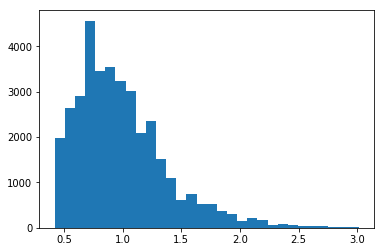

In [10]:
plt.hist(cl.galcat['z'], bins=30)

### Computes the tangential and cross shear profiles

#### Default binning

In [16]:
bin_edges = clmm.polaraveraging.make_bins(0.15, 10, 20, method='evenlog10width')
cl.compute_shear(geometry="flat")
profile = cl.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

/pbs/throng/lsst/software/desc/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/pbs/home/c/ccombet/.local/lib/python3.7/site-packages/clmm-0.2.0-py3.7.egg/clmm/utils.py:43: RuntimeWarning: invalid value encountered in true_divide


### Set up a model

In [17]:
reduced_shear_model = np.zeros(len(profile['radius']))

for i,r in enumerate(profile['radius']): 
    reduced_shear = clmm.predict_reduced_tangential_shear(r*cosmo.h, mass_cl*cosmo.h, 4.,z_cl, profile['z'], cosmo,
                                                        delta_mdef=200,halo_profile_model='nfw')  
    reduced_shear_model[i] = np.mean(reduced_shear)    

Text(0, 0.5, '<shear>')

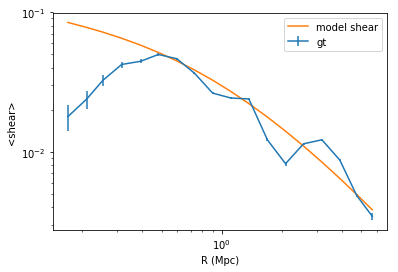

In [18]:
plt.errorbar(profile['radius'],profile['gt'],yerr=profile['gt_err'])
plt.plot(profile['radius'],reduced_shear_model, label='model shear')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (Mpc)')
plt.ylabel('<shear>')